# Vanessa atalanta outbreaks

In [160]:
# libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
from IPython.display import display
import re
from matplotlib import cm, colors

In [161]:
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# get hex color codes of Dark2 matplotlib colormap
cmap = cm.get_cmap('Dark2', 8)
hex = []
for i in range(cmap.N):
    rgba = cmap(i)
    # convert rgb(a) to hex
    hex.append(colors.rgb2hex(rgba))

In [162]:
# data import
count_daily = pd.read_csv('../../data/all_species_count_daily.csv',
                          parse_dates=['date'])

count_by_trap = pd.read_csv('../../data/all_species_count_by_trap.csv',
                            parse_dates=['date'])

### Preliminary analysis for v. atalanta counts including trap direction

<AxesSubplot:xlabel='trap', ylabel='count'>

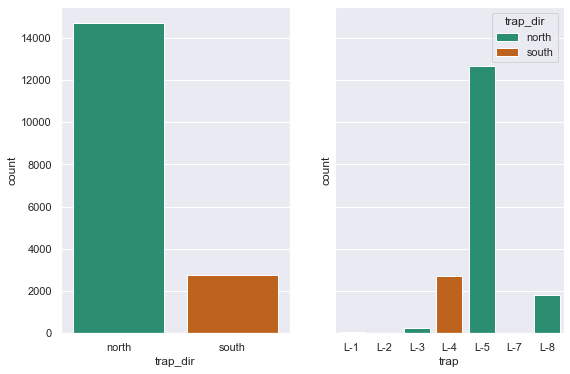

In [163]:
vatalanta = count_by_trap[count_by_trap.species == 'Vanessa atalanta']

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(9,6))
cardinal = vatalanta.groupby('trap_dir', as_index=False)['count'].sum()
traps = vatalanta.groupby(['trap', 'trap_dir'], as_index=False)['count'].sum()

sns.barplot(data=cardinal, x='trap_dir', y='count', ax=axs[0])
sns.barplot(data=traps, x='trap', y='count', 
            hue='trap_dir', dodge=False, hue_order=['north', 'south'], ax=axs[1])

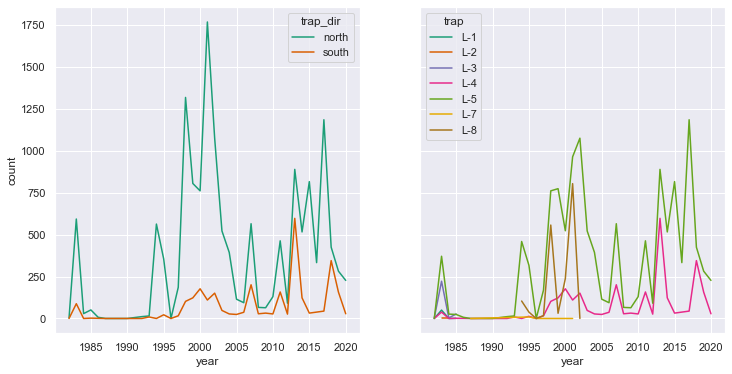

In [164]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6))
cardinal = vatalanta.groupby(['year', 'trap_dir'], as_index=False)['count'].sum(min_count=1)
traps = vatalanta.groupby(['year', 'trap'], as_index=False)['count'].sum(min_count=1)

sns.lineplot(data=cardinal, x='year', y='count', 
             hue='trap_dir', ax=axs[0])
sns.lineplot(data=traps, x='year', y='count', 
             hue='trap', ax=axs[1])

fig.savefig(f'../figs/kaliningrad/vatalanta/trap_dir_yearly.png',
            dpi=600, bbox_inches='tight')

### MEAN SEASONAL PATTERN split into cardinal directions

In [165]:
# focus on years 1998 to 2020
count_by_trap_short = count_by_trap[count_by_trap.year >= 1998].reset_index(drop=True)

# combine counts of same cardinal direction for each day
count_by_dir_short = (
    count_by_trap_short
    .groupby(['species', 'year', 'month', 'day', 'date', 'trap_dir'],
             as_index=False)
    ['count'].sum(min_count=1)
)
count_by_dir_short

,species,year,month,day,date,trap_dir,count
0,Aglais urticae,1998,4,1,1998-04-01,north,NaN
1,Aglais urticae,1998,4,1,1998-04-01,south,NaN
2,Aglais urticae,1998,4,2,1998-04-02,north,NaN
3,Aglais urticae,1998,4,2,1998-04-02,south,NaN
4,Aglais urticae,1998,4,3,1998-04-03,north,NaN
...,...,...,...,...,...,...,...
148345,Vanessa cardui,2020,10,30,2020-10-30,south,NaN
148346,Vanessa cardui,2020,10,31,2020-10-31,north,NaN
148347,Vanessa cardui,2020,10,31,2020-10-31,south,NaN
148348,Vanessa cardui,2020,11,1,2020-11-01,north,NaN


In [166]:
# computing accumulated count for fixed number of observations (i.e., days)
moving_window_size = 21

accumulated_counts = (
    count_by_dir_short
    .groupby(['species', 'trap_dir', 'year']) # for moving window operation,
    .rolling(window=moving_window_size,       # consecutive counts have to be 
             min_periods=1,                   # of same cardinal direction
             center=True,)
    ['count'].sum()
    .sort_index(level=3) # somehow, the order of count values is
)                        # changed, hence, use index to re-order 
                         # the Pandas series!

count_by_dir_short['count_sum'] = accumulated_counts.values # Pandas series has index,
                                                            # hence, just use values!
count_by_dir_short

,species,year,month,day,date,trap_dir,count,count_sum
0,Aglais urticae,1998,4,1,1998-04-01,north,NaN,0.0
1,Aglais urticae,1998,4,1,1998-04-01,south,NaN,0.0
2,Aglais urticae,1998,4,2,1998-04-02,north,NaN,0.0
3,Aglais urticae,1998,4,2,1998-04-02,south,NaN,0.0
4,Aglais urticae,1998,4,3,1998-04-03,north,NaN,0.0
...,...,...,...,...,...,...,...,...
148345,Vanessa cardui,2020,10,30,2020-10-30,south,NaN,NaN
148346,Vanessa cardui,2020,10,31,2020-10-31,north,NaN,0.0
148347,Vanessa cardui,2020,10,31,2020-10-31,south,NaN,NaN
148348,Vanessa cardui,2020,11,1,2020-11-01,north,NaN,0.0


In [167]:
# computing mean count per day (i.e., per fixed number of observations)
count_seasonal = (
    count_by_dir_short
    .groupby(['species', 'month', 'day', 'trap_dir'], as_index=False)
    ['count', 'count_sum'].mean()
)

# the quick & dirty way to get a datetime object column, which is needed for
# plotting soon
count_seasonal['year'] = 1900
count_seasonal['dummy_date'] = pd.to_datetime(count_seasonal[['year', 'month', 'day']])
count_seasonal = count_seasonal.drop('year', axis=1)
count_seasonal

/tmp/ipykernel_5001/880912677.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  count_by_dir_short


,species,month,day,trap_dir,count,count_sum,dummy_date
0,Aglais urticae,4,1,north,0.000000,0.200000,1900-04-01
1,Aglais urticae,4,1,south,0.000000,0.000000,1900-04-01
2,Aglais urticae,4,2,north,0.000000,0.190476,1900-04-02
3,Aglais urticae,4,2,south,0.000000,0.000000,1900-04-02
4,Aglais urticae,4,3,north,0.055556,0.190476,1900-04-03
...,...,...,...,...,...,...,...
6445,Vanessa cardui,10,30,south,NaN,0.000000,1900-10-30
6446,Vanessa cardui,10,31,north,0.000000,0.045455,1900-10-31
6447,Vanessa cardui,10,31,south,NaN,0.000000,1900-10-31
6448,Vanessa cardui,11,1,north,0.333333,0.045455,1900-11-01


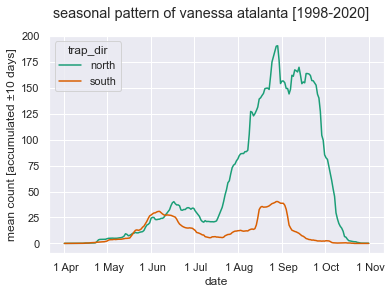

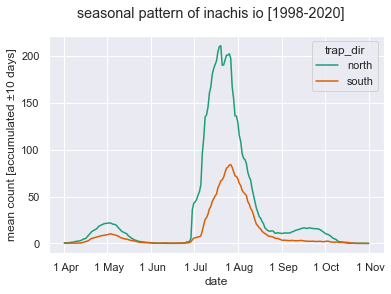

In [168]:
# plotting
# define the date format
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%e %b")

def plot_seasonal(s):
    data = count_seasonal[count_seasonal.species == s]

    fig, ax = plt.subplots()
    sns.lineplot(data=data, x='dummy_date', y='count_sum', hue='trap_dir', ax=ax)

    ax.xaxis.set_major_formatter(date_form)
    ax.set_ylabel(f'mean count [accumulated ±{int((moving_window_size-1)/2)} days]')
    ax.set_xlabel('date')
    fig.suptitle(f'seasonal pattern of {s.lower()} [1998-2020]')
    fig.savefig(f'../figs/kaliningrad/vatalanta/seasonal-pattern_by-dir_{s.replace(" ","-").lower()}.png',
                dpi=600, bbox_inches='tight')

plot_seasonal('Vanessa atalanta')
plot_seasonal('Inachis io')

### Investigate proportion of each direction

In [169]:
# compute proportion of each cardinal direction in mean daily accumulated sum
arr_count_daily = count_seasonal.groupby(['species', 'month', 'day'])['count_sum'].sum().values
arr_count_daily = np.repeat(arr_count_daily, repeats=2)
count_seasonal['count_per'] = count_seasonal.count_sum / arr_count_daily * 100
count_seasonal

,species,month,day,trap_dir,count,count_sum,dummy_date,count_per
0,Aglais urticae,4,1,north,0.000000,0.200000,1900-04-01,100.0
1,Aglais urticae,4,1,south,0.000000,0.000000,1900-04-01,0.0
2,Aglais urticae,4,2,north,0.000000,0.190476,1900-04-02,100.0
3,Aglais urticae,4,2,south,0.000000,0.000000,1900-04-02,0.0
4,Aglais urticae,4,3,north,0.055556,0.190476,1900-04-03,100.0
...,...,...,...,...,...,...,...,...
6445,Vanessa cardui,10,30,south,NaN,0.000000,1900-10-30,0.0
6446,Vanessa cardui,10,31,north,0.000000,0.045455,1900-10-31,100.0
6447,Vanessa cardui,10,31,south,NaN,0.000000,1900-10-31,0.0
6448,Vanessa cardui,11,1,north,0.333333,0.045455,1900-11-01,100.0


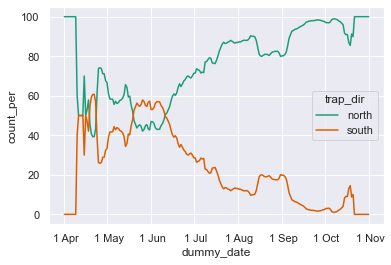

In [170]:
# try to plot proportion of each cardinal direction with daily resolution...
data = count_seasonal[(count_seasonal.species == 'Vanessa atalanta')]

fig, ax = plt.subplots()
sns.lineplot(data=data, x='dummy_date', y='count_per', hue='trap_dir', ax=ax)
#sns.barplot(data=data, x='date', y='count')
ax.xaxis.set_major_formatter(date_form)

The proportion of each cardinal direction is hard to interpret with daily resolution, let's try something else:

In [171]:
# compute monthly means instead of rolling window
count_seasonal_monthly = (
    count_by_dir_short
    .groupby(['species', 'year', 'month', 'trap_dir'], as_index=False)
    ['count'].sum(min_count=1)
    .groupby(['species', 'month', 'trap_dir'], as_index=False)
    ['count'].mean()
)

# compute proportion of each cardinal direction in mean monthly counts
total_monthly_count = count_seasonal_monthly.groupby(['species', 'month'])['count'].sum().values
total_monthly_count = np.repeat(total_monthly_count, repeats=2)
count_seasonal_monthly['count_per'] = count_seasonal_monthly['count'] / total_monthly_count * 100
count_seasonal_monthly['count_per'] = count_seasonal_monthly['count_per'].fillna(0)

count_seasonal_monthly[count_seasonal_monthly.species == 'Vanessa cardui']

,species,month,trap_dir,count,count_per
224,Vanessa cardui,4,north,0.000000,0.000000
225,Vanessa cardui,4,south,0.000000,0.000000
226,Vanessa cardui,5,north,4.782609,28.423773
227,Vanessa cardui,5,south,12.043478,71.576227
228,Vanessa cardui,6,north,90.043478,70.827633
229,Vanessa cardui,6,south,37.086957,29.172367
230,Vanessa cardui,7,north,12.217391,50.539568
231,Vanessa cardui,7,south,11.956522,49.460432
232,Vanessa cardui,8,north,16.826087,72.471910
233,Vanessa cardui,8,south,6.391304,27.528090


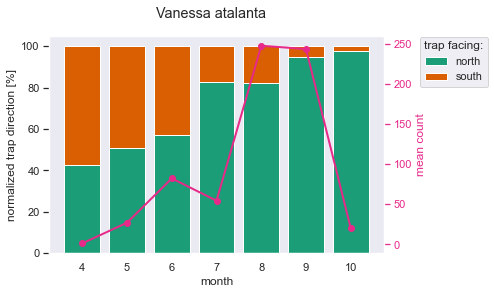

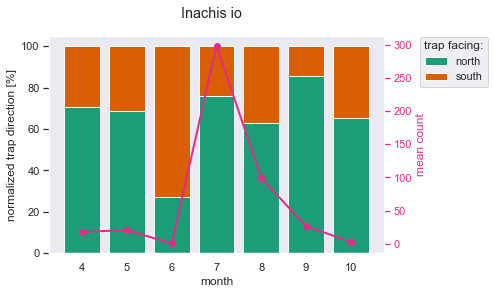

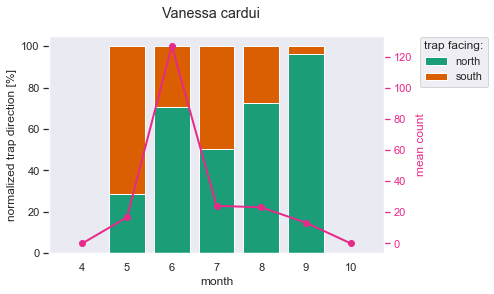

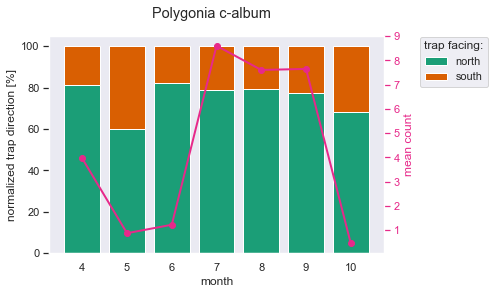

In [172]:
# plotting
sns.set_theme(
    style="dark",
    color_codes=True,
    palette='Dark2',
)

def plot_seasonal_per(s):
    data = count_seasonal_monthly[(count_seasonal_monthly.species == s)
                                & (count_seasonal_monthly.month < 11)] # exclude november

    months = np.arange(4, 11)

    fig, ax = plt.subplots()
    ax_right = ax.twinx()
    ax.bar(
        months,
        data[data.trap_dir == 'north'].count_per.values,
        label='north'        
    )
    ax.bar(
        months,
        data[data.trap_dir == 'south'].count_per.values,
        label='south',
        bottom=data[data.trap_dir == 'north'].count_per.values     
    )
    ax.set_ylabel('normalized trap direction [%]')
    ax.set_xlabel('month')

    ax_right.plot(months, data.groupby(['month'])['count'].sum().values,
                  c=hex[3], lw=2, marker='o')
    ax_right.tick_params(axis='y', colors=hex[3])
    ax_right.set_ylabel('mean count', color=hex[3])
    
    fig.legend(title='trap facing:', loc='center left', bbox_to_anchor=(0.97,0.79))
    fig.suptitle(s)

plot_seasonal_per('Vanessa atalanta')
plot_seasonal_per('Inachis io')
plot_seasonal_per('Vanessa cardui')
plot_seasonal_per('Polygonia c-album')

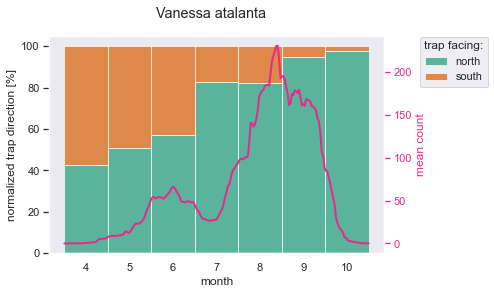

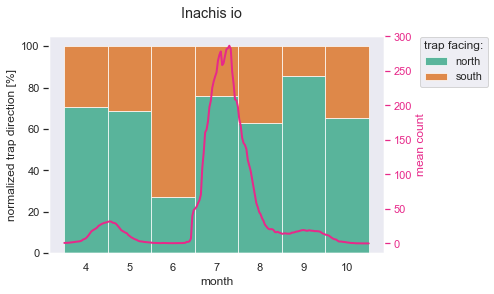

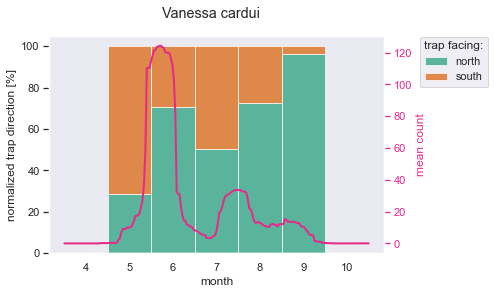

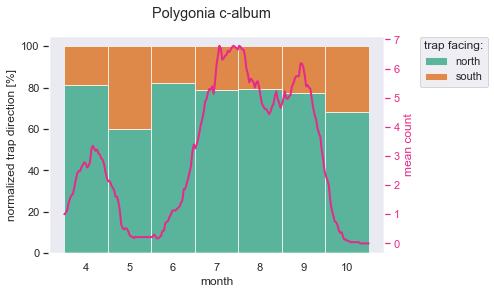

In [173]:
def plot_seasonal_per_daily_count(s):
    bars = count_seasonal_monthly[(count_seasonal_monthly.species == s)
                                & (count_seasonal_monthly.month < 11)] # exclude november
    line = (
        count_seasonal[count_seasonal.species == s]
        .groupby('dummy_date')
        ['count_sum'].sum()
    )
    months = np.arange(4, 11)

    fig, ax = plt.subplots()
    ax.bar(
        months,
        bars[bars.trap_dir == 'north'].count_per.values,
        label='north', 
        width=1, alpha=0.7
    )
    ax.bar(
        months,
        bars[bars.trap_dir == 'south'].count_per.values,
        label='south',
        bottom=bars[bars.trap_dir == 'north'].count_per.values,
        width=1, alpha=0.7   
    )
    ax.set_ylabel('normalized trap direction [%]')
    ax.set_xlabel('month')
 
    secax = ax.twinx()
    secax.tick_params(axis='y', colors=hex[3])
    secax.set_ylabel('mean count', color=hex[3])
    ssecax = secax.twiny()
    ssecax.tick_params(top=False, labeltop=False)
    ssecax.plot(line.index, line.values,
                c=hex[3], lw=2)
    
    fig.legend(title='trap facing:', loc='center left', bbox_to_anchor=(0.97,0.79))
    fig.suptitle(s)
    fig.savefig(f'../figs/kaliningrad/vatalanta/seasonal-pattern_prop_{s.replace(" ","-").lower()}.png',
                dpi=600, bbox_inches='tight')

plot_seasonal_per_daily_count('Vanessa atalanta')
plot_seasonal_per_daily_count('Inachis io')
plot_seasonal_per_daily_count('Vanessa cardui')
plot_seasonal_per_daily_count('Polygonia c-album')

# TODO: Swap x and y axis?

### ABUNDANCE INDEX by season and cardinal direction

In [174]:
# sum up counts in each year
count_outbreak_index = (
    count_by_dir_short
    .groupby(['species', 'year', 'trap_dir'], as_index=False)
    ['count'].sum(min_count=1)
)

# compute total average count (across all years)
avg_count = (
    count_outbreak_index
    .groupby(['species', 'trap_dir'])
    ['count'].median()
)

# add average count to df
count_outbreak_index = count_outbreak_index.set_index(['species', 'trap_dir'])
count_outbreak_index['avg'] = avg_count
count_outbreak_index = count_outbreak_index.reset_index()

# computing outbreak index with zero reflecting the total average count
count_outbreak_index['index'] = count_outbreak_index['count'] - count_outbreak_index['avg']

display(count_outbreak_index)

,species,trap_dir,year,count,avg,index
0,Aglais urticae,north,1998,2.0,12.0,-10.0
1,Aglais urticae,south,1998,0.0,2.0,-2.0
2,Aglais urticae,north,1999,1.0,12.0,-11.0
3,Aglais urticae,south,1999,0.0,2.0,-2.0
4,Aglais urticae,north,2000,2.0,12.0,-10.0
...,...,...,...,...,...,...
685,Vanessa cardui,south,2018,8.0,4.0,4.0
686,Vanessa cardui,north,2019,2134.0,14.0,2120.0
687,Vanessa cardui,south,2019,1136.0,4.0,1132.0
688,Vanessa cardui,north,2020,2.0,14.0,-12.0


Let's do something similar one more time and split the outbreak index into spring (april to june) and summer (july to october) to identify temporal patterns.

In [175]:
def which_season(row):
    if row['month'] < 7:   # define spring as
        val = 'spring'     # april to june, skip
    elif row['month'] > 7: # july, and autumn from
        val = 'autumn'     # august to october
    else:
        val = 'july'
    return val

def outbreaks_per_season(df):
    # add column with spring/summer
    df['season'] = df.apply(which_season, axis=1)
    
    # sum up counts per season
    df = (
        df
        .groupby(['species', 'year', 'season', 'trap_dir'], as_index=False)
        ['count'].sum(min_count=1)
    )

    # compute average (median!) count across all years
    df = df.join(
        df.groupby(['species', 'season', 'trap_dir'])['count'].median(),
        on=['species', 'season', 'trap_dir'],
        rsuffix='_avg'
    )
    # computing outbreak index with zero reflecting the total average count
    df['index'] = df['count'] - df['count_avg']
    return df

count_outbreak_index_season = outbreaks_per_season(count_by_dir_short)
count_outbreak_index_season

,species,year,season,trap_dir,count,count_avg,index
0,Aglais urticae,1998,autumn,north,2.0,3.0,-1.0
1,Aglais urticae,1998,autumn,south,0.0,0.0,0.0
2,Aglais urticae,1998,july,north,0.0,1.0,-1.0
3,Aglais urticae,1998,july,south,0.0,0.0,0.0
4,Aglais urticae,1998,spring,north,0.0,2.0,-2.0
...,...,...,...,...,...,...,...
2065,Vanessa cardui,2020,autumn,south,1.0,1.0,0.0
2066,Vanessa cardui,2020,july,north,0.0,1.0,-1.0
2067,Vanessa cardui,2020,july,south,0.0,0.0,0.0
2068,Vanessa cardui,2020,spring,north,2.0,2.0,0.0


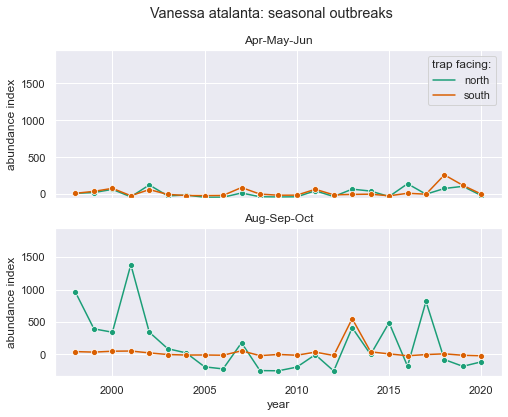

In [176]:
sns.set_theme(
    style="darkgrid",
    color_codes=True,
    palette='Dark2',
)

# plotting
def outbreak_index_per_season(s):

    data = count_outbreak_index_season[
        (count_outbreak_index_season['species'] == s)
    ]

    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,6))
    sns.lineplot(data=data[data.season == 'spring'], x='year', y='index',
                 hue='trap_dir', marker='o', ax=axs[0])
    sns.lineplot(data=data[data.season == 'autumn'], x='year', y='index',
                 hue='trap_dir', marker='o', ax=axs[1], legend=False)
    axs[0].set_title('Apr-May-Jun')
    axs[1].set_title('Aug-Sep-Oct')
    for i in range(len(axs)):
        axs[i].set_ylabel('abundance index')
        axs[i].set_ylim(top=1950)
    fig.suptitle(f'{s}: seasonal outbreaks')
    axs[0].legend(title='trap facing:')
    fig.savefig(f'../figs/kaliningrad/vatalanta/outbreaks_per_season_{s.replace(" ","-").lower()}.png',
                dpi=600, bbox_inches='tight')

outbreak_index_per_season('Vanessa atalanta')